# **IMPORT & LOAD**

In [2]:
# CELL 1: Library Imports
import os # For handling file paths and directories
import random # For random number generation
import numpy as np # For numerical operations
import pandas as pd # For data manipulation and analysis
import matplotlib.pyplot as plt # For plotting and visualization
import seaborn as sns # For statistical data visualization
from tqdm import tqdm # For progress bars

import tensorflow as tf # For building and training neural networks
from tensorflow.keras.preprocessing.image import ImageDataGenerator # For image data augmentation
from tensorflow.keras.models import Model, Sequential   # For building neural network models
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D # For defining layers in neural networks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint # For training callbacks
from tensorflow.keras.applications import EfficientNetB0 # For transfer learning with EfficientNetB0

from sklearn.metrics import classification_report, confusion_matrix # For evaluating model performance
from sklearn.model_selection import train_test_split # For splitting data into training and testing sets

In [18]:
# CELL 2: Dataset Splitting into Train/Val/Test
import shutil

# Define paths
base_dir = r"images"
output_dir = r"dataset"

# # Define ratios
split_ratio = [0.7, 0.15, 0.15]  # 70% train, 15% val, 15% test

# Loop through each class folder
for category in ['benign', 'malignant', 'normal']:
    files = os.listdir(os.path.join(base_dir, category))
    random.shuffle(files)
    train_split = int(split_ratio[0] * len(files))
    val_split = int(split_ratio[1] * len(files))

    subsets = {
        'train': files[:train_split],
        'val': files[train_split:train_split+val_split],
        'test': files[train_split+val_split:]
    }

    for subset, subset_files in subsets.items():

        subset_path = os.path.join(output_dir, subset, category)
        os.makedirs(subset_path, exist_ok=True)

        for f in subset_files:
            shutil.copy(os.path.join(base_dir, category, f),
                        os.path.join(subset_path, f))
print("✅ Dataset successfully split into train/val/test folders!")


✅ Dataset successfully split into train/val/test folders!


In [19]:
# CELL 2: Load Images into TensorFlow Datasets

# Set constants
data_dir = r"dataset"
img_height, img_width = 224, 224
batch_size = 32

# Load training, validation, and test sets
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=f"{data_dir}/train",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
)


val_ds = tf.keras.utils.image_dataset_from_directory(
    directory=f"{data_dir}/val",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    directory=f"{data_dir}/test",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)

print("✅ Datasets loaded successfully!")
print("Classes:", train_ds.class_names)


Found 1103 files belonging to 3 classes.
Found 236 files belonging to 3 classes.
Found 239 files belonging to 3 classes.
✅ Datasets loaded successfully!
Classes: ['benign', 'malignant', 'normal']


In [29]:
# CELL 3: How many data under each class in each category

# Define dataset root and expected splits and categories
dataset_root = 'dataset'  # Update this to your dataset's root folder path if different
splits = ['train', 'test', 'val']
categories = ['benign', 'malignant', 'normal']

# Initialize dictionary to hold counts
image_counts = {split: {} for split in splits}

for split in splits:
    for category in categories:
        dir_path = os.path.join(dataset_root, split, category)
        if os.path.exists(dir_path):
            count = len([f for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f))])
        else:
            count = 0  # In case the folder doesn't exist
        image_counts[split][category] = count

# Print results
for split in splits:
    print(f"=== {split.upper()} ===")
    for category in categories:
        print(f"{category}: {image_counts[split][category]}")
    print()


=== TRAIN ===
benign: 623
malignant: 294
normal: 186

=== TEST ===
benign: 135
malignant: 64
normal: 41

=== VAL ===
benign: 133
malignant: 63
normal: 40



# **AUGMENTATION AND AUTOTUNE**

In [30]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)

In [31]:
total = 836 + 404 + 260

class_weights = {
    0: total / (3 * 836),    # benign
    1: total / (3 * 404),    # malignant
    2: total / (3 * 260)     # normal
}

class_weights

{0: 0.5980861244019139, 1: 1.2376237623762376, 2: 1.9230769230769231}

In [32]:
from tensorflow.keras import layers, models
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomBrightness(0.2),
    layers.GaussianNoise(0.05)
], name="augmentation_layer")

In [33]:
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3)
)

base_model.trainable = False   # Stage 1: Freeze

In [34]:
inputs = layers.Input(shape=(224,224,3))
x = data_augmentation(inputs)
x = tf.keras.applications.efficientnet.preprocess_input(x)

x = base_model(x, training=False)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.4)(x)

outputs = layers.Dense(3, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)

model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation_layer (Sequential) │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,378,278 (16.70 MB)

 Trainable params: 328,707 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [35]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [36]:
history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    class_weight=class_weights,
)

Epoch 1/20


35/35 ━━━━━━━━━━━━━━━━━━━━ 105s 3s/step - accuracy: 0.6954 - loss: 0.6646 - val_accuracy: 0.7924 - val_loss: 0.4696
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.7806 - loss: 0.4806 - val_accuracy: 0.7966 - val_loss: 0.4700
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.7743 - loss: 0.4930 - val_accuracy: 0.8051 - val_loss: 0.3917
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.8150 - loss: 0.4146 - val_accuracy: 0.7881 - val_loss: 0.4223
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 107s 3s/step - accuracy: 0.7996 - loss: 0.4457 - val_accuracy: 0.8008 - val_loss: 0.4099
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 112s 3s/step - accuracy: 0.8214 - loss: 0.4196 - val_accuracy: 0.7924 - val_loss: 0.4408
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.8205 - loss: 0.4193 - val_accuracy: 0.7881 - val_loss: 0.4848
Epoch 8/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.8277 - loss: 0.3959 - val_accuracy: 0.7924 - val_loss: 0.4869

KeyboardInterrupt: 

In [12]:
base_model.trainable = True

for layer in base_model.layers[:300]:   # freeze first 300 layers
    layer.trainable = False

In [13]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [37]:
history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=8,
    class_weight=class_weights
)

Epoch 1/8
35/35 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.8422 - loss: 0.3346 - val_accuracy: 0.8263 - val_loss: 0.3990
Epoch 2/8
35/35 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.8540 - loss: 0.3366 - val_accuracy: 0.8432 - val_loss: 0.3652
Epoch 3/8
35/35 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.8314 - loss: 0.3710 - val_accuracy: 0.8305 - val_loss: 0.3413
Epoch 4/8
35/35 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.8522 - loss: 0.3601 - val_accuracy: 0.8220 - val_loss: 0.3803
Epoch 5/8
35/35 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.8377 - loss: 0.3532 - val_accuracy: 0.8220 - val_loss: 0.3946
Epoch 6/8
35/35 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.8595 - loss: 0.3385 - val_accuracy: 0.8008 - val_loss: 0.4407
Epoch 7/8
35/35 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.8450 - loss: 0.3600 - val_accuracy: 0.8263 - val_loss: 0.3734
Epoch 8/8
35/35 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.8395 - loss: 0.3603 - val_accuracy: 0.8305 - val_loss: 0.3467


In [38]:
print(history1.history.keys())
print(history2.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


In [39]:
acc = history1.history['accuracy'] + history2.history['accuracy']
val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
loss = history1.history['loss'] + history2.history['loss']
val_loss = history1.history['val_loss'] + history2.history['val_loss']

model.save("final_model.keras")
model = tf.keras.models.load_model("final_model.keras")

test_loss, test_acc = model.evaluate(test_ds)
print("TEST ACCURACY:", test_acc)


8/8 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.7699 - loss: 0.4960
TEST ACCURACY: 0.7698744535446167


In [40]:
# best val accuracy during initial training
print("Best VAL ACC Stage 1:", max(history1.history['val_accuracy']))

# best val accuracy during fine-tuning
print("Best VAL ACC Stage 2:", max(history2.history['val_accuracy']))

# evaluate final model on full validation set
val_loss, val_acc = model.evaluate(val_ds)
print("Final Validation Accuracy:", val_acc)

Best VAL ACC Stage 1: 0.8929924368858337
Best VAL ACC Stage 2: 0.8432203531265259
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8305 - loss: 0.3467
Final Validation Accuracy: 0.8305084705352783


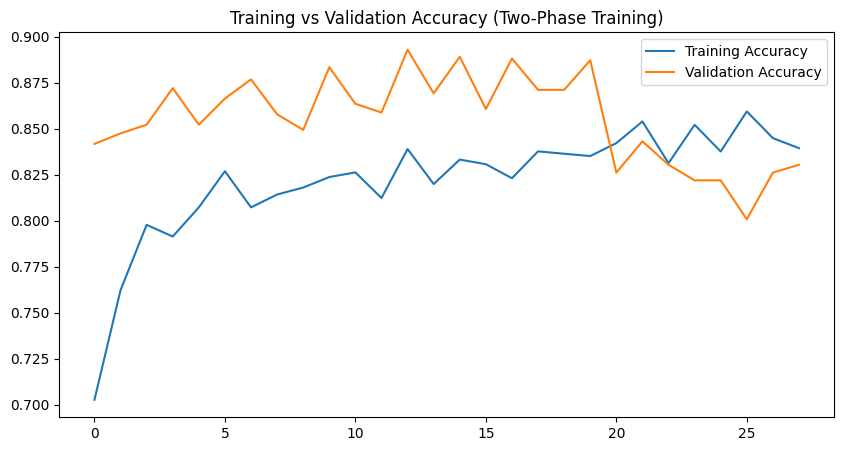

In [41]:
acc = history1.history["accuracy"] + history2.history["accuracy"]
val_acc = history1.history["val_accuracy"] + history2.history["val_accuracy"]

epochs_range = range(len(acc))

plt.figure(figsize=(10,5))
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy (Two-Phase Training)")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


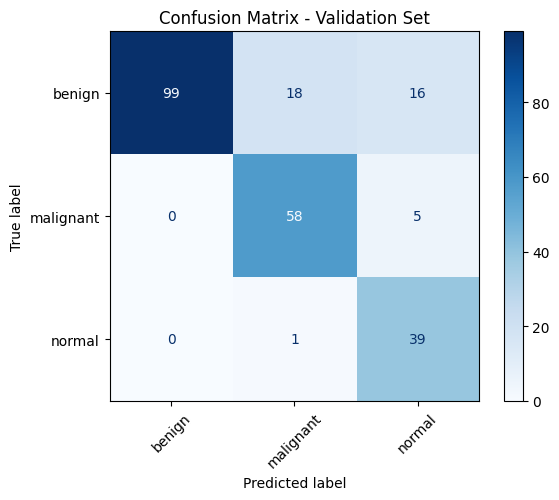

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['benign', 'malignant', 'normal'])
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - Validation Set")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


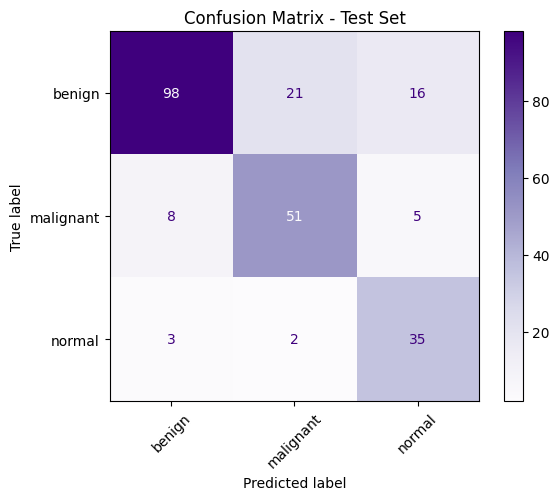

In [43]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['benign', 'malignant', 'normal'])
disp.plot(cmap='Purples', xticks_rotation=45)
plt.title("Confusion Matrix - Test Set")
plt.show()


In [44]:
from sklearn.metrics import classification_report

y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print(classification_report(y_true, y_pred, target_names=['benign','malignant','normal']))


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 850ms/step
              precision    recall  f1-score   support

      benign       0.90      0.73      0.80       135
   malignant       0.69      0.80      0.74        64
      normal       0.62      0.88      0.73        40

    accuracy                           0.77       239
   macro avg       0.74      0.80      0.76       239
weighted avg       0.80      0.77      0.77       239



1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 838ms/step


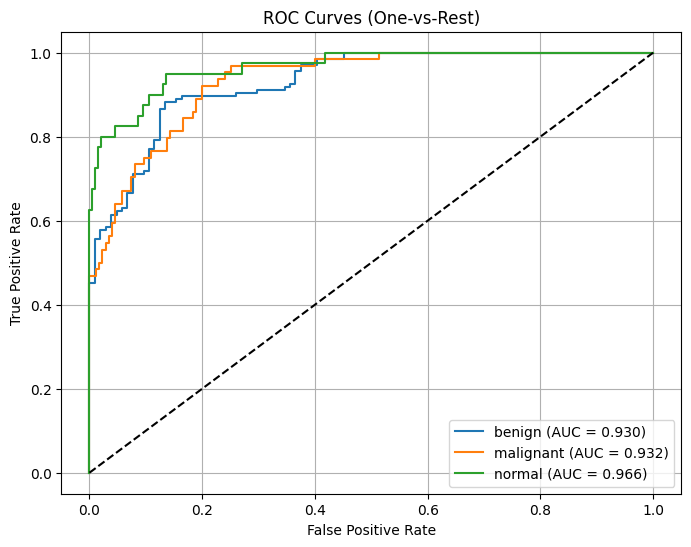

In [45]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

n_classes = 3
class_names = ['benign','malignant','normal']

# Collect predictions
y_true = []
y_prob = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_prob.extend(preds)

y_true = np.array(y_true)
y_prob = np.array(y_prob)

# Binarize true labels
y_true_bin = label_binarize(y_true, classes=[0,1,2])

plt.figure(figsize=(8,6))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest)")
plt.legend()
plt.grid(True)
plt.show()


In [55]:
import numpy as np

def ds_to_numpy(dataset):
    X, y = [], []
    for images, labels in dataset:
        X.append(images.numpy())
        y.append(labels.numpy())
    X = np.concatenate(X, axis=0)
    y = np.concatenate(y, axis=0)
    return X, y

X_train, y_train = ds_to_numpy(train_ds)
X_val,   y_val   = ds_to_numpy(val_ds)
X_test,  y_test  = ds_to_numpy(test_ds)

X_train.shape, X_val.shape, X_test.shape


((1103, 224, 224, 3), (236, 224, 224, 3), (239, 224, 224, 3))

In [56]:
import tensorflow as tf

feature_extractor = tf.keras.applications.EfficientNetB0(
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg',
    weights='imagenet'
)

X_train_f = feature_extractor.predict(X_train)
X_val_f   = feature_extractor.predict(X_val)
X_test_f  = feature_extractor.predict(X_test)

X_train_f.shape


35/35 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step


(1103, 1280)

In [57]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softmax',
    num_class=3,
    eval_metric='mlogloss'
)

xgb.fit(X_train_f, y_train)

,objective,'multi:softmax'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [58]:
from sklearn.metrics import accuracy_score, classification_report

# Validation
val_pred = xgb.predict(X_val_f)
print("Validation Accuracy:", accuracy_score(y_val, val_pred))

# Test
test_pred = xgb.predict(X_test_f)
print("Test Accuracy:", accuracy_score(y_test, test_pred))

print("\nClassification Report:")
print(classification_report(y_test, test_pred, target_names=['benign', 'malignant', 'normal']))

Validation Accuracy: 0.9067796610169492
Test Accuracy: 0.8744769874476988

Classification Report:
              precision    recall  f1-score   support

      benign       0.88      0.90      0.89       135
   malignant       0.88      0.81      0.85        64
      normal       0.83      0.88      0.85        40

    accuracy                           0.87       239
   macro avg       0.87      0.86      0.86       239
weighted avg       0.87      0.87      0.87       239



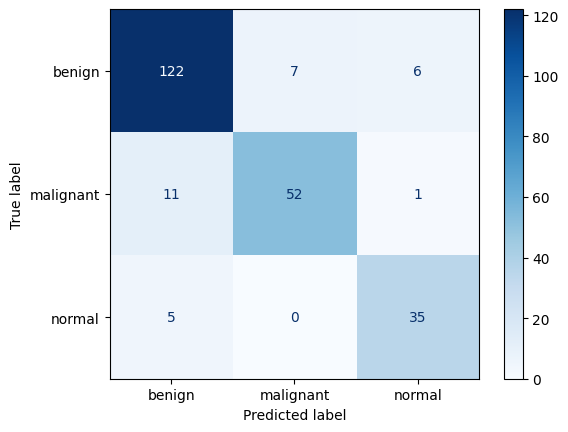

In [59]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, test_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['benign','malignant','normal'])
disp.plot(cmap='Blues')
plt.show()


----

In [64]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Probabilities
test_proba = xgb.predict_proba(X_test_f)

# Binarize labels for multiclass AUC
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

auc = roc_auc_score(
    y_test_bin,
    test_proba,
    multi_class="ovr",
    average="macro"
)

print("ROC-AUC:", auc)


ROC-AUC: 0.9729763140420594


In [62]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softprob',   # <-- FIXED
    num_class=3,
    eval_metric='mlogloss'
)

xgb.fit(X_train_f, y_train)


,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [ ]:
evals = [(X_train_f, y_train), (X_val_f, y_val)]

xgb.fit(
    X_train_f, y_train,
    eval_set=evals,
    verbose=False
)


---